##### from example - https://github.com/napoles-uach/MediumPost/blob/main/CoraDGL.ipynb

In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

In [2]:

from dgl.data import CoraGraphDataset

dataset = CoraGraphDataset()
g = dataset[0]
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
test_mask = g.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:

import pandas as pd
df=pd.DataFrame(features[0:500].numpy())

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(500, 1433)

Text(189.58333333333334, 0.5, 'Node Index')

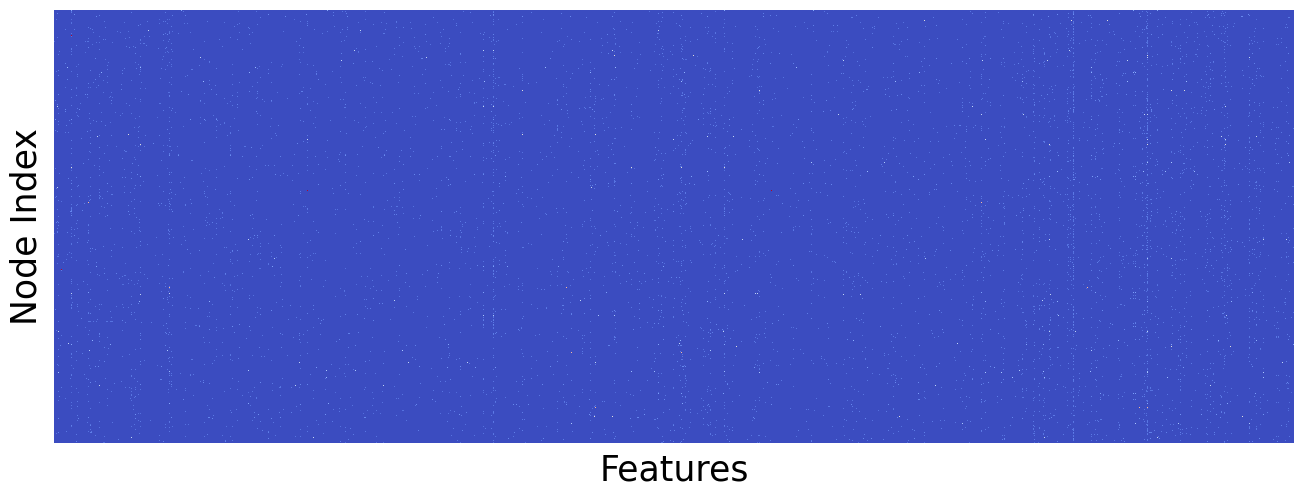

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (16,16))
ax=sns.heatmap(df[range(1433)],cmap='coolwarm',square=True,cbar=False,xticklabels=False,yticklabels=False)
plt.xlabel('Features',fontsize=25)
plt.ylabel('Node Index',fontsize=25)

In [7]:

 

from dgl.nn import GraphConv
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GraphConv(1433, 8*16) #activation default=None
        self.layer2 = GraphConv(8*16, 7)    #activation default=None


    def forward(self, g, features):
        x1 = F.relu(self.layer1(g, features)) #ReLU activation function
        x2 = self.layer2(g, x1)
        return x2
net = Net()

In [8]:

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [9]:
import numpy as np
g.add_edges(g.nodes(), g.nodes())
optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
loss_list=[]
acc_list=[]
all_logits=[]
for epoch in range(200):
    net.train()
    logits = net(g, features)
    
    #print(logits)
    logp = F.log_softmax(logits, 1)
    all_logits.append(logp)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(net, g, features, labels, test_mask)
    loss_list.append(loss.item())
    acc_list.append(acc)

Text(0, 0.5, 'Accuracy')

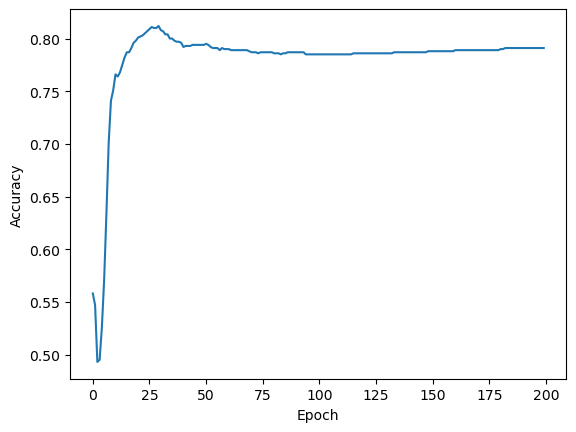

In [10]:

plt.plot(acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [11]:

import pandas as pd
df=pd.DataFrame(all_logits[199][:].detach().numpy())

In [12]:
lista=[]
for i in range(len(labels)):
  lista.append((all_logits[199][i].detach().numpy().argmax()))

df['Class']=pd.Series(lista)

In [13]:


fails=[]
pred_lab=df['Class'].to_list()
lab_list=labels.tolist()
for i in range(len(lab_list)):
  if lab_list[i] != pred_lab[i]:
    fails.append([i,lab_list[i],pred_lab[i]])